In [1]:
#========================================================================
# Copyright 2019 Science Technology Facilities Council
# Copyright 2019 University of Manchester
#
# This work is part of the Core Imaging Library developed by Science Technology	
# Facilities Council and University of Manchester
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0.txt
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# 
#=========================================================================

In [2]:
# some utilities
# imports
from ccpi.framework import ImageData, ImageGeometry
from ccpi.framework import AcquisitionData, AcquisitionGeometry
from ccpi.astra.operators import AstraProjectorSimple 

import numpy as np
import matplotlib.pyplot as plt

# simulate 'ideal', i.e. noise-free, sino
def get_ideal_sino(data, N, n_angles):
    
    # get ImageGeometry
    ig = data.geometry

    # Create AcquisitionGeometry
    angles = np.linspace(0, np.pi, n_angles, dtype=np.float32)

    ag = AcquisitionGeometry(geom_type = "parallel",
                             dimension = "2D", 
                             angles = angles,
                             pixel_num_h = N)

    dev = "cpu"

    Aop = AstraProjectorSimple(ig, ag, dev)    
    sino = Aop.direct(data)
    return sino.as_array()

# Framework basics

The goal of this notebook is to cover the Framework building blocks. We do not expect participants to step through all the cells. We suggest to use this notebook as a reference for other exercises or for independent trials in future.

## CT geometry

In conventional CT systems, an object is placed between a source emitting X-rays and a detector array measuring the  X-ray transmission images of the incident X-rays. Typically, either the object is placed on a rotating sample stage and rotates with respect to the source-detector assembly, or the source-detector gantry rotates with respect to the stationary object. This arrangement results in so-called *circular scanning trajectory*. Depending on source and detector types, there are three conventional data acquisition geometries:
 - parallel geometry (2D or 3D),
 - fan-beam geometry, and
 - cone-beam geometry.

*Parallel geometry*

Parallel beams of X-rays are emitted onto 1D (single pixel row) or 2D detector array. This geometry is common for synchrotron sources. 2D parrallel geometry is illustrated below.

<img src="figures/parallel.png" width=500 height=500 align="left">

3D parallel geometry is a stack of 2D slices each having 2D parallel geometry. 

<img src="figures/parallel3d.png" width=600 height=600 align="left">

*Fan-beam geometry*

A single point-like X-ray source emits a cone beam onto 1D detector pixel row. Cone-beam is typically collimated to imaging field of view. Collimation allows greatly reduce amount of scatter radiation reaching the detector. Fan-beam geometry is used when scattering has significant influence on image quality or single-slice reconstruction is sufficient.

<img src="figures/fan.png" width=500 height=500 align="left">

*Cone-beam geometry*

A single point-like X-ray source emits a cone beam onto 2D detector array. Cone-beam geometry is mainly used in lab-based CT instruments.

<img src="figures/cone.png" width=600 height=600 align="left">

### Parallel geometry
#### AcquisitionGeometry and AcquisitionData

In the Framework, we implemented `AcquisitionGeometry` class to hold acquisition parameters and `ImageGeometry` to hold geometry of a reconstructed volume. Corresponding data arrays are wrapped as `AcquisitionData` and `ImageData` classes, respectively.

The simplest (of course from image processing point of view, not from physical implementation) geometry is the parallel geometry. Geometrical parameters for parallel geometry are depicted below:

<a id='2d_parallel_geometry'></a>
<img src="figures/parallel_geometry.png" width=600 height=600 align="left">

In the Framework, we define `AcquisitionGeometry` as follows.

In [3]:
# imports
from ccpi.framework import AcquisitionGeometry
import numpy as np

# acquisition angles
n_angles = 90
angles = np.linspace(0, np.pi, n_angles, dtype = np.float32)

# number of pixels in detector row
N = 256

# pixel size
pixel_size_h = 1

# # create AcquisitionGeometry
ag_par = AcquisitionGeometry(geom_type = 'parallel',
                             dimension = '2D',
                             angles = angles,
                             pixel_num_h = N,
                             pixel_size_h = pixel_size_h)


print('Acquisition geometry:\n{}'.format(ag_par))

Acquisition geometry:
Number of dimensions: 2D
angles: [0.         0.03529879 0.07059759 0.10589638 0.14119518 0.17649397
 0.21179277 0.24709156 0.28239036 0.31768915 0.35298795 0.38828674
 0.42358553 0.45888433 0.49418312 0.5294819  0.5647807  0.6000795
 0.6353783  0.67067707 0.7059759  0.74127465 0.7765735  0.81187224
 0.84717107 0.88246983 0.91776866 0.9530674  0.98836625 1.0236651
 1.0589638  1.0942626  1.1295614  1.1648602  1.200159   1.2354578
 1.2707566  1.3060554  1.3413541  1.376653   1.4119518  1.4472506
 1.4825493  1.5178481  1.553147   1.5884458  1.6237445  1.6590433
 1.6943421  1.7296408  1.7649397  1.8002385  1.8355373  1.870836
 1.9061348  1.9414337  1.9767325  2.0120313  2.0473301  2.0826287
 2.1179276  2.1532264  2.1885252  2.223824   2.2591228  2.2944217
 2.3297205  2.365019   2.400318   2.4356167  2.4709156  2.5062144
 2.5415132  2.576812   2.6121109  2.6474094  2.6827083  2.718007
 2.753306   2.7886047  2.8239036  2.8592024  2.8945012  2.9297998
 2.9650986  3.000397

`AcquisitionGeometry` contains only metadata, the actual data is wrapped in `AcquisitionData` class.`AcquisiitonGeometry` class also holds information about arrangement of the actual acquisition data array. We use attribute `dimension_labels` to label axis. The expected dimension labels are shown below:

<a id='2d_parallel_labels'></a>
<img src="figures/parallel_data.png" width=300 height=300 align="left">

The default order of dimensions for `AcquisitionData` is `[angle, horizontal]`, meaning that the number of elements along 0 and 1 axes in the acquisition data array is expected to be `n_angles` and `N`, respectively.

In [4]:
print('Dimension labels:\n{}'.format(ag_par.dimension_labels))

Dimension labels:
[u'angle', u'horizontal']


<a id='acquisition_data'></a>
To have consistent `AcquisitionData` and `AcquisitionGeometry`, we recommend to allocate `AcquisitionData` using `allocate` method of `AcquisitionGeometry` class:

In [5]:
# imports
from ccpi.framework import AcquisitionData

# allocate AcquisitionData
ad_par = ag_par.allocate()

print('Dimensions and Labels = {}, {}'.format(ad_par.shape, ad_par.dimension_labels))

Dimensions and Labels = (90, 256), {0: u'angle', 1: u'horizontal'}


Now, we can pass actual sinogram to `AcquisitionData`:

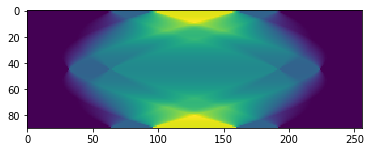

In [6]:
# imports
import matplotlib.pyplot as plt
%matplotlib inline

from ccpi.framework import TestData
import os, sys

# load test image
# initialise loader
loader = TestData(data_dir = os.path.join(sys.prefix, "share", "ccpi"))
# load data
data = loader.load(TestData.SIMPLE_PHANTOM_2D, size = (N, N))
# scale data
data *= 2.5 / N
ad_par.fill(get_ideal_sino(data, N, n_angles))

# show sinogram
plt.imshow(ad_par.as_array())
plt.show()

#### ImageGeometry and ImageData

To store reconstruction results, we implemented two classes:`ImageGeometry` and `ImageData` class. Similar to `AcquisitionData` and `AcquisitionGeometry`, we first define 2D [`ImageGeometry`](#2d_parallel_geometry) and then allocate [`ImageData`](#2d_parallel_labels).

In [7]:
# imports
from ccpi.framework import ImageData, ImageGeometry

# define 2D ImageGeometry
# given AcquisitionGeometry ag_par, default parameters for corresponding ImageData
ig_par = ImageGeometry(voxel_num_y = ag_par.pixel_num_h, 
                       voxel_size_x = ag_par.pixel_size_h,
                       voxel_num_x = ag_par.pixel_num_h,
                       voxel_size_y = ag_par.pixel_size_h)

# allocate ImageData filled with 0 values with the specific geometry
im_data1 = ig_par.allocate()
# allocate ImageData filled with random values with the specific geometry
im_data2 = ig_par.allocate('random', seed = 5)

In [8]:
print('Allocate with zeros \n{}\n'.format(im_data1.as_array()))
print('Allocate with random numbers in [0,1] \n{}\n'.format(im_data2.as_array()))
print('Dimensions and Labels = {} , {}'.format(im_data1.shape, im_data1.dimension_labels))

Allocate with zeros 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Allocate with random numbers in [0,1] 
[[0.22199318 0.8707323  0.20671916 ... 0.57537466 0.63371646 0.88892853]
 [0.71395904 0.26511267 0.00970831 ... 0.6778535  0.00210485 0.68233746]
 [0.98002124 0.21300386 0.71321696 ... 0.38721627 0.05082141 0.28317612]
 ...
 [0.8071209  0.27829176 0.70057    ... 0.813863   0.9379623  0.07552729]
 [0.8812209  0.71720845 0.9509081  ... 0.7440719  0.37709934 0.11136404]
 [0.49854606 0.1762441  0.58227324 ... 0.9399168  0.34108707 0.27401248]]

Dimensions and Labels = (256, 256) , {0: u'horizontal_y', 1: u'horizontal_x'}


Default parameters are recommended to fully exploit detector resolution but they can be chosen based on other considerations. For instance, to reconstruct on coarser grid:

In [9]:
ig_par1 = ImageGeometry(voxel_num_y = ag_par.pixel_num_h / 2, 
                        voxel_size_x = ag_par.pixel_size_h * 2,
                        voxel_num_x = ag_par.pixel_num_h / 2,
                        voxel_size_y = ag_par.pixel_size_h * 2)

im_data3 = ig_par1.allocate('random', seed = 5)

print('Dimensions and Labels = {} , {}'.format(im_data3.shape, im_data3.dimension_labels))

Dimensions and Labels = (128, 128) , {0: u'horizontal_y', 1: u'horizontal_x'}


### 3D parallel, fan-beam and cone-beam geometries 

Fan-beam, cone-beam and 3D (multi-slice) parallel geometry can be set-up similar to 2D parallel geometry. 

#### 3D parallel geometry

Geometrical parameters and dimension labels for 3D parallel beam geometry:

<img src="figures/parallel3d_geometry.png" width=700 height=700 align="left">

<img src="figures/parallel3d_data.png" width=600 height=600 align="left">

In [10]:
# set-up 3D parallel beam AcquisitionGeometry
# physical pixel size
pixel_size_h = 1
ag_par_3d = AcquisitionGeometry(geom_type = 'parallel', 
                                dimension = '3D', 
                                angles = angles, 
                                pixel_num_h = N, 
                                pixel_size_h = pixel_size_h, 
                                pixel_num_v = N, 
                                pixel_size_v = pixel_size_h)

print('Fan-beam acquisition geometry:\n{}'.format(ag_par_3d))
print('Dimension labels:\n{}'.format(ag_par_3d.dimension_labels))

Fan-beam acquisition geometry:
Number of dimensions: 3D
angles: [0.         0.03529879 0.07059759 0.10589638 0.14119518 0.17649397
 0.21179277 0.24709156 0.28239036 0.31768915 0.35298795 0.38828674
 0.42358553 0.45888433 0.49418312 0.5294819  0.5647807  0.6000795
 0.6353783  0.67067707 0.7059759  0.74127465 0.7765735  0.81187224
 0.84717107 0.88246983 0.91776866 0.9530674  0.98836625 1.0236651
 1.0589638  1.0942626  1.1295614  1.1648602  1.200159   1.2354578
 1.2707566  1.3060554  1.3413541  1.376653   1.4119518  1.4472506
 1.4825493  1.5178481  1.553147   1.5884458  1.6237445  1.6590433
 1.6943421  1.7296408  1.7649397  1.8002385  1.8355373  1.870836
 1.9061348  1.9414337  1.9767325  2.0120313  2.0473301  2.0826287
 2.1179276  2.1532264  2.1885252  2.223824   2.2591228  2.2944217
 2.3297205  2.365019   2.400318   2.4356167  2.4709156  2.5062144
 2.5415132  2.576812   2.6121109  2.6474094  2.6827083  2.718007
 2.753306   2.7886047  2.8239036  2.8592024  2.8945012  2.9297998
 2.9650986 

Given `ag_par_3d` acquisition geometry, default `ImageGeometry` parameters can be set up as follows:

In [11]:
# set-up 3D parallel beam ImageGeometry
ig_par_3d = ImageGeometry(voxel_num_x = ag_par_3d.pixel_num_h,
                          voxel_size_x = ag_par_3d.pixel_size_h,
                          voxel_num_y = ag_par_3d.pixel_num_h,
                          voxel_size_y = ag_par_3d.pixel_size_h,
                          voxel_num_z = ag_par_3d.pixel_num_v,
                          voxel_size_z = ag_par_3d.pixel_size_v)

print('Fan-beam image geometry:\n{}'.format(ig_par_3d))
print('Dimension labels:\n{}'.format(ig_par_3d.dimension_labels))

Fan-beam image geometry:
Number of channels: 1
voxel_num : x256,y256,z256
voxel_size : x1,y1,z1
center : x0,y0,z0

Dimension labels:
[u'vertical', u'horizontal_y', u'horizontal_x']


<a id='fan_beam_geometry'></a>
#### Fan-beam geometry

Geometrical parameters and dimension labels for fan-beam geometry:

<img src="figures/fan_geometry.png" width=700 height=700 align="left">

<img src="figures/fan_data.png" width=450 height=450 align="left">

In [12]:
# set-up fan-beam AcquisitionGeometry
# distance from source to center of rotation
dist_source_center = 200.0
# distance from center of rotation to detector
dist_center_detector = 300.0
# physical pixel size
pixel_size_h = 2
ag_fan = AcquisitionGeometry(geom_type = 'cone', 
                             dimension = '2D', 
                             angles = angles, 
                             pixel_num_h = N, 
                             pixel_size_h = pixel_size_h, 
                             dist_source_center = dist_source_center, 
                             dist_center_detector = dist_center_detector)

print('Fan-beam acquisition geometry:\n{}'.format(ag_fan))
print('Dimension labels:\n{}'.format(ag_fan.dimension_labels))

Fan-beam acquisition geometry:
Number of dimensions: 2D
angles: [0.         0.03529879 0.07059759 0.10589638 0.14119518 0.17649397
 0.21179277 0.24709156 0.28239036 0.31768915 0.35298795 0.38828674
 0.42358553 0.45888433 0.49418312 0.5294819  0.5647807  0.6000795
 0.6353783  0.67067707 0.7059759  0.74127465 0.7765735  0.81187224
 0.84717107 0.88246983 0.91776866 0.9530674  0.98836625 1.0236651
 1.0589638  1.0942626  1.1295614  1.1648602  1.200159   1.2354578
 1.2707566  1.3060554  1.3413541  1.376653   1.4119518  1.4472506
 1.4825493  1.5178481  1.553147   1.5884458  1.6237445  1.6590433
 1.6943421  1.7296408  1.7649397  1.8002385  1.8355373  1.870836
 1.9061348  1.9414337  1.9767325  2.0120313  2.0473301  2.0826287
 2.1179276  2.1532264  2.1885252  2.223824   2.2591228  2.2944217
 2.3297205  2.365019   2.400318   2.4356167  2.4709156  2.5062144
 2.5415132  2.576812   2.6121109  2.6474094  2.6827083  2.718007
 2.753306   2.7886047  2.8239036  2.8592024  2.8945012  2.9297998
 2.9650986 

Given `ag_fan` acquisition geometry, default `ImageGeometry` parameters can be set up as follows:

In [13]:
# set-up fan-beam ImageGeometry

# calculate geometrical magnification
mag = (ag_fan.dist_source_center + ag_fan.dist_center_detector) / ag_fan.dist_source_center

ig_fan = ImageGeometry(voxel_num_x = ag_fan.pixel_num_h,
                       voxel_size_x = ag_fan.pixel_size_h / mag,
                       voxel_num_y = ag_fan.pixel_num_h,
                       voxel_size_y = ag_fan.pixel_size_h / mag)

print('Fan-beam image geometry:\n{}'.format(ig_fan))
print('Dimension labels:\n{}'.format(ig_fan.dimension_labels))

Fan-beam image geometry:
Number of channels: 1
voxel_num : x256,y256,z0
voxel_size : x0.8,y0.8,z1
center : x0,y0,z0

Dimension labels:
[u'horizontal_y', u'horizontal_x']


<a id='cone_beam_geometry'></a>
#### Cone-beam geometry

Geometrical parameters and dimension labels for cone-beam geometry:

<img src="figures/cone_data.png" width=650 height=650 align="left">

<img src="figures/cone_geometry.png" width=800 height=800 align="left">

In [14]:
# set-up cone-beam geometry
# distance from source to center of rotation
dist_source_center = 200.0
# distance from center of rotation to detector
dist_center_detector = 300.0
# physical pixel size
pixel_size_h = 2

ag_cone = AcquisitionGeometry(geom_type = 'cone', 
                             dimension = '3D', 
                             angles = angles, 
                             pixel_num_h = N, 
                             pixel_size_h = pixel_size_h, 
                             pixel_num_v = N, 
                             pixel_size_v = pixel_size_h, 
                             dist_source_center = dist_source_center, 
                             dist_center_detector = dist_center_detector)

print('Cone-beam acquisition geometry:\n{}'.format(ag_cone))
print('Dimension labels:\n{}'.format(ag_cone.dimension_labels))

Cone-beam acquisition geometry:
Number of dimensions: 3D
angles: [0.         0.03529879 0.07059759 0.10589638 0.14119518 0.17649397
 0.21179277 0.24709156 0.28239036 0.31768915 0.35298795 0.38828674
 0.42358553 0.45888433 0.49418312 0.5294819  0.5647807  0.6000795
 0.6353783  0.67067707 0.7059759  0.74127465 0.7765735  0.81187224
 0.84717107 0.88246983 0.91776866 0.9530674  0.98836625 1.0236651
 1.0589638  1.0942626  1.1295614  1.1648602  1.200159   1.2354578
 1.2707566  1.3060554  1.3413541  1.376653   1.4119518  1.4472506
 1.4825493  1.5178481  1.553147   1.5884458  1.6237445  1.6590433
 1.6943421  1.7296408  1.7649397  1.8002385  1.8355373  1.870836
 1.9061348  1.9414337  1.9767325  2.0120313  2.0473301  2.0826287
 2.1179276  2.1532264  2.1885252  2.223824   2.2591228  2.2944217
 2.3297205  2.365019   2.400318   2.4356167  2.4709156  2.5062144
 2.5415132  2.576812   2.6121109  2.6474094  2.6827083  2.718007
 2.753306   2.7886047  2.8239036  2.8592024  2.8945012  2.9297998
 2.9650986

Given `ag_cone` acquisition geometry, default `ImageGeometry` parameters can be calculated as follows:
**TODO** Add mathematical expression for magnification

In [15]:
# cone-beam ImageGeometry
# calculate geometrical magnification
mag = (ag_cone.dist_source_center + ag_cone.dist_center_detector) / ag_cone.dist_source_center

ig_cone = ImageGeometry(voxel_num_x = ag_cone.pixel_num_h,
                        voxel_size_x = ag_cone.pixel_size_h / mag,
                        voxel_num_y = ag_cone.pixel_num_h,
                        voxel_size_y = ag_cone.pixel_size_h / mag,
                        voxel_num_z = ag_cone.pixel_num_v,
                        voxel_size_z = ag_cone.pixel_size_v / mag)

print('Cone-beam image geometry:\n{}'.format(ig_cone))
print('Dimension labels:\n{}'.format(ig_cone.dimension_labels))

Cone-beam image geometry:
Number of channels: 1
voxel_num : x256,y256,z256
voxel_size : x0.8,y0.8,z0.8
center : x0,y0,z0

Dimension labels:
[u'vertical', u'horizontal_y', u'horizontal_x']


## Operating AcquisitionData and ImageData

### Methods

`AcquisiionData` and `ImageData` inherit from the same parent `DataContainer` class, therefore they behave the same way.

There are algebraic operations defined for both `AcquisiionData` and `ImageData`. Following operations are defined:

binary operations (between two DataContainers or scalar and DataContainer)
- \+ addition
- \- subtraction
- \/ division
- \* multiplication
- \** power
- maximum
- minimum
    
in-place operations
- \+= 
- \-= 
- \*=
- \**=
- /=     

unary operations
- abs
- sqrt
- sign
- conjugate
    
reductions
- minimum
- maximum
- sum
- norm
- dot product

Here are examples of operations listed above for `AcquistionData`: 

In [16]:
a = ag_par.allocate(2)
b = ag_par.allocate(3)
print('a \n{}\n'.format(a.as_array()))
print('b \n{}\n'.format(b.as_array()))

a 
[[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]

b 
[[3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 ...
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]]



In [17]:
## binary operations
c = a + b
print('a + b \n{}\n'.format(c.as_array()))
# or alternatively
c = a.add(b)
print('a + b \n{}\n'.format(c.as_array()))
d = 3 ** a
print('3 ** a \n{}\n'.format(d.as_array()))
e = a ** b
print('a ** b \n{}\n'.format(e.as_array()))
f = a.maximum(b)
print('max(a,b) \n{}\n'.format(f.as_array()))

a + b 
[[5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]
 ...
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]]

a + b 
[[5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]
 ...
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]]

3 ** a 
[[9. 9. 9. ... 9. 9. 9.]
 [9. 9. 9. ... 9. 9. 9.]
 [9. 9. 9. ... 9. 9. 9.]
 ...
 [9. 9. 9. ... 9. 9. 9.]
 [9. 9. 9. ... 9. 9. 9.]
 [9. 9. 9. ... 9. 9. 9.]]

a ** b 
[[8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 ...
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]]

max(a,b) 
[[3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 ...
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]]



In [18]:
## in-place operations
b **= b
print('b ** b \n{}\n'.format(b.as_array()))
a += b
print('a + b \n{}\n'.format(a.as_array()))
# or alternatively
a.add(b, out = a)
print('a + b \n{}\n'.format(a.as_array()))

b ** b 
[[27. 27. 27. ... 27. 27. 27.]
 [27. 27. 27. ... 27. 27. 27.]
 [27. 27. 27. ... 27. 27. 27.]
 ...
 [27. 27. 27. ... 27. 27. 27.]
 [27. 27. 27. ... 27. 27. 27.]
 [27. 27. 27. ... 27. 27. 27.]]

a + b 
[[29. 29. 29. ... 29. 29. 29.]
 [29. 29. 29. ... 29. 29. 29.]
 [29. 29. 29. ... 29. 29. 29.]
 ...
 [29. 29. 29. ... 29. 29. 29.]
 [29. 29. 29. ... 29. 29. 29.]
 [29. 29. 29. ... 29. 29. 29.]]

a + b 
[[56. 56. 56. ... 56. 56. 56.]
 [56. 56. 56. ... 56. 56. 56.]
 [56. 56. 56. ... 56. 56. 56.]
 ...
 [56. 56. 56. ... 56. 56. 56.]
 [56. 56. 56. ... 56. 56. 56.]
 [56. 56. 56. ... 56. 56. 56.]]



In [19]:
## unary operation
g = a.sign()
print('sign(a) \n{}\n'.format(g.as_array()))

sign(a) 
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]



In [20]:
## reductions
h = a.norm()
print('norm(a) \n{}\n'.format(h))
i = a.dot(b)
print('dot(a,b) \n{}\n'.format(i))

norm(a) 
8500.20214844

dot(a,b) 
34836480.0



A few examples for `ImageData`:

In [21]:
a = ig_par.allocate(2)
b = ig_par.allocate(3)
print('a \n{}\n'.format(a.as_array()))
print('b \n{}\n'.format(b.as_array()))

a 
[[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]

b 
[[3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 ...
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]]



In [22]:
c = a + b
print('a + b \n{}\n'.format(c.as_array()))
b **= b
print('b ** b \n{}\n'.format(b.as_array()))
a += b
print('a + b \n{}\n'.format(a.as_array()))
g = a.sign()
print('sign(a) \n{}\n'.format(g.as_array()))
h = a.norm()
print('norm(a) \n{}\n'.format(h))

a + b 
[[5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]
 ...
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]
 [5. 5. 5. ... 5. 5. 5.]]

b ** b 
[[27. 27. 27. ... 27. 27. 27.]
 [27. 27. 27. ... 27. 27. 27.]
 [27. 27. 27. ... 27. 27. 27.]
 ...
 [27. 27. 27. ... 27. 27. 27.]
 [27. 27. 27. ... 27. 27. 27.]
 [27. 27. 27. ... 27. 27. 27.]]

a + b 
[[29. 29. 29. ... 29. 29. 29.]
 [29. 29. 29. ... 29. 29. 29.]
 [29. 29. 29. ... 29. 29. 29.]
 ...
 [29. 29. 29. ... 29. 29. 29.]
 [29. 29. 29. ... 29. 29. 29.]
 [29. 29. 29. ... 29. 29. 29.]]

sign(a) 
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]

norm(a) 
7424.0



<a id='image_data'></a>
The Framework provides a number of test images

- BOAT = 'boat.tiff'
- CAMERA = 'camera.png'
- PEPPERS = 'peppers.tiff'
- RESOLUTION_CHART = 'resolution_chart.tiff'
- SIMPLE_PHANTOM_2D = 'hotdog'
- SHAPES = 'shapes.png'
    
Here we load a 'hotdog' image (a simple CT phantom consisting of 2 materials).

In [23]:
# imports
from ccpi.framework import TestData
import os, sys

# initialise loader
loader = TestData(data_dir=os.path.join(sys.prefix, 'share','ccpi'))
data = loader.load(TestData.SIMPLE_PHANTOM_2D, size=(200,200))
# get ImageGeometry
ig = data.geometry

In [24]:
print('ImageGeometry:\n{}'.format(ig))
print('Dimensions and Labels = {}, {}'.format(data.shape, data.dimension_labels))

ImageGeometry:
Number of channels: 1
voxel_num : x200,y200,z0
voxel_size : x1,y1,z1
center : x0,y0,z0

Dimensions and Labels = (200, 200), {0: u'horizontal_x', 1: u'horizontal_y'}


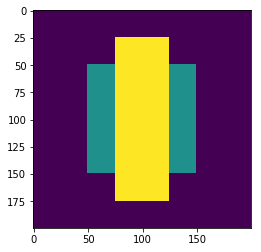

In [25]:
# plot data
plt.imshow(data.as_array())
plt.show()

`AcquisitionData` and `ImageData` provide a simple method to produce a subset of itself based on the axis we would like to have. 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Direct invocation is deprecated and will be removed in following version. Use allocate from ImageGeometry instead
  


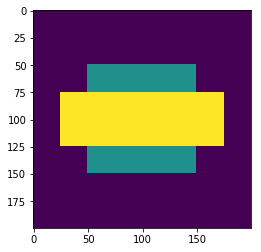

In [26]:
# transpose data using subset method
data_subset = data.subset(['horizontal_y', 'horizontal_x'])

plt.imshow(data_subset.as_array())
plt.show()

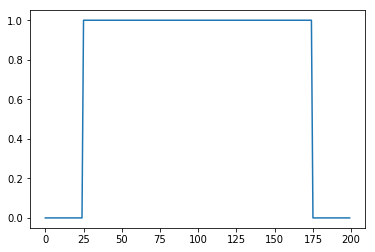

In [27]:
# extract single row
data_profile = data_subset.subset(horizontal_y = 100)

plt.plot(data_profile.as_array())
plt.show()

A middle slice of [cone-beam data](#cone_beam_geometry) has [fan-beam geometry](#fan_beam_geometry). Get middle slice from cone-beam `AcquisitionData` using the subset method:

In [28]:
# allocate cone-beam acquisition data
ad_cone = ag_cone.allocate('random', seed = 5)

print('3D cone image geometry:\n {}'.format(ad_cone.geometry))

3D cone image geometry:
 Number of dimensions: 3D
angles: [0.         0.03529879 0.07059759 0.10589638 0.14119518 0.17649397
 0.21179277 0.24709156 0.28239036 0.31768915 0.35298795 0.38828674
 0.42358553 0.45888433 0.49418312 0.5294819  0.5647807  0.6000795
 0.6353783  0.67067707 0.7059759  0.74127465 0.7765735  0.81187224
 0.84717107 0.88246983 0.91776866 0.9530674  0.98836625 1.0236651
 1.0589638  1.0942626  1.1295614  1.1648602  1.200159   1.2354578
 1.2707566  1.3060554  1.3413541  1.376653   1.4119518  1.4472506
 1.4825493  1.5178481  1.553147   1.5884458  1.6237445  1.6590433
 1.6943421  1.7296408  1.7649397  1.8002385  1.8355373  1.870836
 1.9061348  1.9414337  1.9767325  2.0120313  2.0473301  2.0826287
 2.1179276  2.1532264  2.1885252  2.223824   2.2591228  2.2944217
 2.3297205  2.365019   2.400318   2.4356167  2.4709156  2.5062144
 2.5415132  2.576812   2.6121109  2.6474094  2.6827083  2.718007
 2.753306   2.7886047  2.8239036  2.8592024  2.8945012  2.9297998
 2.9650986  3.000

In [29]:
# extract middle-slice
# AcquisitionData container
ad_middle_slice = ad_cone.subset(vertical = int(ad_cone.geometry.pixel_num_v / 2))
# and corresponding AcquisitionGeometry
ag_middle_slice = ad_middle_slice.geometry

print('Dimensions and Labels = {}, {}\n'.format(ad_middle_slice.shape, ad_middle_slice.dimension_labels))
print('Middle slice acquisition geometry:\n {}'.format(ag_middle_slice))

Dimensions and Labels = (90, 256), {0: u'angle', 1: u'horizontal'}

Middle slice acquisition geometry:
 Number of dimensions: 2D
angles: [0.         0.03529879 0.07059759 0.10589638 0.14119518 0.17649397
 0.21179277 0.24709156 0.28239036 0.31768915 0.35298795 0.38828674
 0.42358553 0.45888433 0.49418312 0.5294819  0.5647807  0.6000795
 0.6353783  0.67067707 0.7059759  0.74127465 0.7765735  0.81187224
 0.84717107 0.88246983 0.91776866 0.9530674  0.98836625 1.0236651
 1.0589638  1.0942626  1.1295614  1.1648602  1.200159   1.2354578
 1.2707566  1.3060554  1.3413541  1.376653   1.4119518  1.4472506
 1.4825493  1.5178481  1.553147   1.5884458  1.6237445  1.6590433
 1.6943421  1.7296408  1.7649397  1.8002385  1.8355373  1.870836
 1.9061348  1.9414337  1.9767325  2.0120313  2.0473301  2.0826287
 2.1179276  2.1532264  2.1885252  2.223824   2.2591228  2.2944217
 2.3297205  2.365019   2.400318   2.4356167  2.4709156  2.5062144
 2.5415132  2.576812   2.6121109  2.6474094  2.6827083  2.718007
 2.7

### Read/ write AcquisitionData and ImageData

The Framework provides classes to read and write `AcquisitionData` and `ImageData` as NEXUS files. 

In [30]:
# imports
from ccpi.io import NEXUSDataWriter, NEXUSDataReader

# initialise NEXUS Writer
writer = NEXUSDataWriter()
writer.set_up(file_name = '/home/sirfuser/tmp_nexus.nxs',
              data_container = ad_middle_slice)
# write data
writer.write_file()

/usr/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [31]:
# read data
# initialize NEXUS reader
reader = NEXUSDataReader()
reader.set_up(nexus_file = '/home/sirfuser/tmp_nexus.nxs')
# load data
ad1 = reader.load_data()
# get AcquisiionGeometry
ag1 = reader.get_geometry()

In [32]:
print('Dimensions and Labels = {}, {}\n'.format(ad1.shape, ad1.dimension_labels))
print('Acquisition geometry:\n {}'.format(ag1))

Dimensions and Labels = (90, 256), {0: u'angle', 1: u'horizontal'}

Acquisition geometry:
 Number of dimensions: 2D
angles: [0.         0.03529879 0.07059759 0.10589638 0.14119518 0.17649397
 0.21179277 0.24709156 0.28239036 0.31768915 0.35298795 0.38828674
 0.42358553 0.45888433 0.49418312 0.5294819  0.5647807  0.6000795
 0.6353783  0.67067707 0.7059759  0.74127465 0.7765735  0.81187224
 0.84717107 0.88246983 0.91776866 0.9530674  0.98836625 1.0236651
 1.0589638  1.0942626  1.1295614  1.1648602  1.200159   1.2354578
 1.2707566  1.3060554  1.3413541  1.376653   1.4119518  1.4472506
 1.4825493  1.5178481  1.553147   1.5884458  1.6237445  1.6590433
 1.6943421  1.7296408  1.7649397  1.8002385  1.8355373  1.870836
 1.9061348  1.9414337  1.9767325  2.0120313  2.0473301  2.0826287
 2.1179276  2.1532264  2.1885252  2.223824   2.2591228  2.2944217
 2.3297205  2.365019   2.400318   2.4356167  2.4709156  2.5062144
 2.5415132  2.576812   2.6121109  2.6474094  2.6827083  2.718007
 2.753306   2.788

### Processor
`Processor` takes as an input `DataContainer` and returns either another `DataContainer` or some number. The aim of this class is to simplify the writing of processing pipelines.

#### Resizer
Quite often we need either crop or downsample data; `Resizer` provides a convinient way to perform these operations for both `ImageData` and `AcquisitionData`. Here we use sinogram from this [example](#image_data).

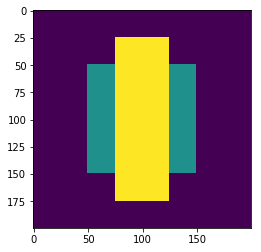

In [33]:
# imports
from ccpi.processors import Resizer

# show test image
plt.imshow(data.as_array())
plt.show()

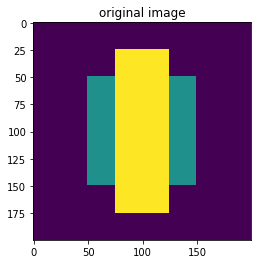

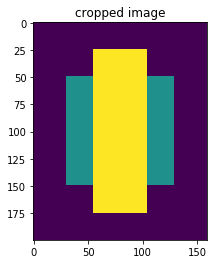

In [34]:
# crop ImageData along 1st dimension
# initialise Resizer
resizer_crop = Resizer(binning = [1, 1], roi = [-1, (20,180)])
# pass DataContainer
resizer_crop.input = data
data_cropped = resizer_crop.process()
# get new ImageGeometry
ig_data_cropped = data_cropped.geometry

plt.imshow(data.as_array())
plt.title('original image')
plt.show()

plt.imshow(data_cropped.as_array())
plt.title('cropped image')
plt.show()

In [35]:
print('Original image, dimensions and Labels = {}, {}\n'.format(data.shape, data.dimension_labels))
print('Cropped image, dimensions and Labels = {}, {}\n'.format(data_cropped.shape, data_cropped.dimension_labels))
print('Original ImageGeometry:\n{}'.format(ig))
print('Cropped ImageGeometry:\n{}'.format(ig_data_cropped))

Original image, dimensions and Labels = (200, 200), {0: u'horizontal_x', 1: u'horizontal_y'}

Cropped image, dimensions and Labels = (200, 160), {0: u'horizontal_x', 1: u'horizontal_y'}

Original ImageGeometry:
Number of channels: 1
voxel_num : x200,y200,z0
voxel_size : x1,y1,z1
center : x0,y0,z0

Cropped ImageGeometry:
Number of channels: 1
voxel_num : x200,y160,z0
voxel_size : x1,y1,z1
center : x0,y0,z0



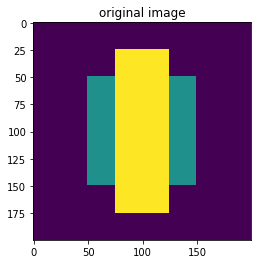

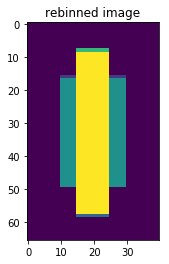

In [37]:
# re-bin ImageData
# initialise Resizer
resizer_rebin = Resizer(binning = [3, 5], roi = -1)
# pass the image
resizer_rebin.input = data
data_rebinned = resizer_rebin.process()
# get new ImageGeometry
ig_data_rebinned = data_rebinned.geometry

plt.imshow(data.as_array())
plt.title('original image')
plt.show()

plt.imshow(data_rebinned.as_array())
plt.title('rebinned image')
plt.show()

In [38]:
print('Original image, dimensions and Labels = {}, {}\n'.format(data.shape, data.dimension_labels))
print('Rebinned image, dimensions and Labels = {}, {}\n'.format(data_rebinned.shape, data_rebinned.dimension_labels))
print('Original ImageGeometry:\n{}'.format(ig))
print('Rebinned ImageGeometry:\n{}'.format(ig_data_rebinned))

Original image, dimensions and Labels = (200, 200), {0: u'horizontal_x', 1: u'horizontal_y'}

Rebinned image, dimensions and Labels = (66, 40), {0: u'horizontal_x', 1: u'horizontal_y'}

Original ImageGeometry:
Number of channels: 1
voxel_num : x200,y200,z0
voxel_size : x1,y1,z1
center : x0,y0,z0

Rebinned ImageGeometry:
Number of channels: 1
voxel_num : x66,y40,z0
voxel_size : x3,y5,z1
center : x0,y0,z0



#### Calculation of Center of Rotation
In the ideal alignment of a CT instrument, orthogonal projection of an axis of rotation onto a detector has to coincide with a vertical midline of the detector. This is barely feasible in practice due to misalignment and/ or kinematic errors in positioning of CT instrument components. A slight offset of the center of rotation with respect to the theoretical position will contribute to the loss of resolution; in more severe cases, it will cause severe artifacts in the reconstructed volume (double-borders). `CenterOfRotationFinder` allows to estimate offset of center of rotation from theoretical. In the current release of the Framework `CenterOfRotationFinder` supports only parallel geometry. Here we use sinogram from this [example](#acquisition_data). 
**TODO** cite nghia vo

In [40]:
# imports
from ccpi.processors import CenterOfRotationFinder

#plt.imshow(ad_par.as_array())
#plt.show()

# initialise CenterOfRotationFinder
#cor = CenterOfRotationFinder()
#cor.set_input(ad_par)
#center_of_rotation = cor.get_output()
#print(center_of_rotation)

## Multi-channel data

Both `AcquisitionGeometry`/ `AcquisitionData` and `ImageGeometry`/ `ImageData` can be defined for multi-channel (spectral) CT data using `channels` attribute.

In [41]:
# multi-channel fan-beam geometry
ag_fan_mc = AcquisitionGeometry(geom_type = 'cone', 
                                 dimension = '2D', 
                                 angles = angles, 
                                 pixel_num_h = N, 
                                 pixel_size_h = 1, 
                                 dist_source_center = 200, 
                                 dist_center_detector = 300,
                                 channels = 10)

print('Multi-channel fan-beam geometry:\n{}'.format(ag_fan_mc))
print('Number of channels:{}\n'.format(ag_fan_mc.channels))
print('Labels = {}'.format(im_data3.dimension_labels))

Multi-channel fan-beam geometry:
Number of dimensions: 2D
angles: [0.         0.03529879 0.07059759 0.10589638 0.14119518 0.17649397
 0.21179277 0.24709156 0.28239036 0.31768915 0.35298795 0.38828674
 0.42358553 0.45888433 0.49418312 0.5294819  0.5647807  0.6000795
 0.6353783  0.67067707 0.7059759  0.74127465 0.7765735  0.81187224
 0.84717107 0.88246983 0.91776866 0.9530674  0.98836625 1.0236651
 1.0589638  1.0942626  1.1295614  1.1648602  1.200159   1.2354578
 1.2707566  1.3060554  1.3413541  1.376653   1.4119518  1.4472506
 1.4825493  1.5178481  1.553147   1.5884458  1.6237445  1.6590433
 1.6943421  1.7296408  1.7649397  1.8002385  1.8355373  1.870836
 1.9061348  1.9414337  1.9767325  2.0120313  2.0473301  2.0826287
 2.1179276  2.1532264  2.1885252  2.223824   2.2591228  2.2944217
 2.3297205  2.365019   2.400318   2.4356167  2.4709156  2.5062144
 2.5415132  2.576812   2.6121109  2.6474094  2.6827083  2.718007
 2.753306   2.7886047  2.8239036  2.8592024  2.8945012  2.9297998
 2.965098

In [42]:
# define multi-channel 2D ImageGeometry
ig3 = ImageGeometry(voxel_num_y = 5, voxel_num_x = 4, channels = 2)

# create random integer in [0, max_value] ImageData with the specific geometry
im_data3 = ig3.allocate('random_int', seed = 10, max_value = 500)

print('Allocate with random integers \n{}\n'.format(im_data3.as_array()))
print('Dimensions and Labels  =  {}, {}'.format(im_data3.shape, im_data3.dimension_labels))

Allocate with random integers 
[[[265. 125. 484.  15.]
  [320. 369. 123. 156.]
  [473. 221. 496. 413.]
  [369.   8.  73. 256.]
  [490.  40. 420. 371.]]

 [[ 16. 356. 239. 395.]
  [ 54. 344. 363. 122.]
  [ 62.  33. 200. 356.]
  [462. 177. 179.  54.]
  [ 77. 453.  13. 243.]]]

Dimensions and Labels  =  (2, 5, 4), {0: u'channel', 1: u'horizontal_y', 2: u'horizontal_x'}


All the methods described for single-channel data in the sections above are also defined for multi-channel data.

In [43]:
# allocate multi-channel fan-beam acquisition data
ad_fan_mc = ag_fan_mc.allocate()

# extract single channel from multi-channel fan-beam data using subset method
ad_fan_sc = ad_fan_mc.subset(channel = 5)
ag_fan_sc = ad_fan_mc.geometry

print('Geometry:\n{}'.format(ag_fan_sc))
print('Dimensions and Labels  =  {}, {}'.format(ad_fan_sc.shape, ad_fan_sc.dimension_labels))

Geometry:
Number of dimensions: 2D
angles: [0.         0.03529879 0.07059759 0.10589638 0.14119518 0.17649397
 0.21179277 0.24709156 0.28239036 0.31768915 0.35298795 0.38828674
 0.42358553 0.45888433 0.49418312 0.5294819  0.5647807  0.6000795
 0.6353783  0.67067707 0.7059759  0.74127465 0.7765735  0.81187224
 0.84717107 0.88246983 0.91776866 0.9530674  0.98836625 1.0236651
 1.0589638  1.0942626  1.1295614  1.1648602  1.200159   1.2354578
 1.2707566  1.3060554  1.3413541  1.376653   1.4119518  1.4472506
 1.4825493  1.5178481  1.553147   1.5884458  1.6237445  1.6590433
 1.6943421  1.7296408  1.7649397  1.8002385  1.8355373  1.870836
 1.9061348  1.9414337  1.9767325  2.0120313  2.0473301  2.0826287
 2.1179276  2.1532264  2.1885252  2.223824   2.2591228  2.2944217
 2.3297205  2.365019   2.400318   2.4356167  2.4709156  2.5062144
 2.5415132  2.576812   2.6121109  2.6474094  2.6827083  2.718007
 2.753306   2.7886047  2.8239036  2.8592024  2.8945012  2.9297998
 2.9650986  3.0003974  3.0356963